In [ ]:
!pip install -U datasets

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("tasksource/esci", split="train[:50000]")
train_dataset.shape

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(50000, 14)

In [ ]:
test_dataset = load_dataset("tasksource/esci", split="test[:10000]")
test_dataset.shape

(10000, 14)

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

In [ ]:
train_df.info()

In [ ]:
## Dropping cols from the dataset as they seem unnecessary for the task
cols_to_be_dropped = [
    "example_id", "query_id", "product_id",
    "small_version", "large_version",
]
train_df = train_df.drop(columns=cols_to_be_dropped, axis = 1)
test_df = test_df.drop(columns=cols_to_be_dropped, axis = 1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   query                 50000 non-null  object
 1   product_locale        50000 non-null  object
 2   esci_label            50000 non-null  object
 3   product_title         50000 non-null  object
 4   product_description   20771 non-null  object
 5   product_bullet_point  47297 non-null  object
 6   product_brand         48828 non-null  object
 7   product_color         34670 non-null  object
 8   product_text          50000 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In the problem, organizer gave the following relevance scores

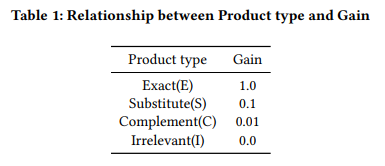

In [ ]:
train_df["esci_label"].value_counts()

,count
esci_label,
Exact,24337
Substitute,12474
Irrelevant,12106
Complement,1083


In [ ]:
mapping = {
    "Exact" : 1.0,
    "Substitute" : 0.1,
    "Irrelevant" : 0.0,
    "Complement" : 0.01
}

train_df["esci_label"] = train_df["esci_label"].map(mapping)
test_df["esci_label"] = test_df["esci_label"].map(mapping)

In [ ]:
train_df.head()

Created a new column that we'll feed into the cross-encoder, note that this column will be fed into the cross encoder to fine-tune it.

The data contains information of the form:

`[CLS] product_info[prod1] [SEP] product_info[prod2] [SEP]` and so on

In [ ]:
product_cols = [
    "product_title",
    "product_description",
    "product_bullet_point",
    "product_brand",
    "product_color",
    "product_text"
]

def create_input(df, product_cols):
    df[product_cols] = df[product_cols].fillna("")

    def clean_text(text):
        # cleaning text to prevent ParseErrors that will give you headache later
        return (
            str(text)
            .replace('"', "'")         # Replace double quotes to prevent ParseErrors
            .replace("\n", ' ')
            .replace("\r", ' ')
            .strip()
        )

    def build_row(row):
        parts = [f'{col}: {clean_text(row[col])}' for col in product_cols]
        return "[CLS] " + " ".join(parts) + " [SEP]"

    df["product_input"] = df.apply(build_row, axis=1)
    return df

train_df = create_input(train_df, product_cols)
test_df = create_input(test_df, product_cols)

In [ ]:
processed_train_df = train_df[["query", "product_input", "esci_label"]]
processed_test_df = test_df[["query", "product_input", "esci_label"]]

In [ ]:
# processed_train_df.to_csv("processed_train_updated.csv", index=False)
# processed_test_df.to_csv("processed_test_updated.csv", index=False)

In [ ]:
import csv

processed_train_df.to_csv("processed_train_updated.csv", index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
processed_test_df.to_csv("processed_test_updated.csv", index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

In [ ]:
from google.colab import files
files.download('processed_train_updated.csv')
files.download('processed_test_updated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>